# refellips demo: Solid/Air
This demo presents a comparison between refellips and WVASE outputs as well as an example use case for fitting single-wavelength multi-angle ellipsometry data with refellips.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from refnx.analysis import CurveFitter
from refnx.reflect import Slab

In [3]:
# Will need to add the repo directory to sys.path (system specific)
sys.path.append('../')

from refellips import RI, DataSE, ReflectModelSE, ObjectiveSE

### Import data

In [4]:
dname = 'testData1_11nm_PNIPAM_on_Si_EP4.dat'
data = DataSE(data=dname)

WVASE_test = pd.read_csv(open('WVASE_example_2nmSiO2_11nmPNIPAM_658nm.txt','r'))

In [8]:
pwd

'/Users/andrew/Documents/Andy/programming/refellips/demos'

### Build model

In [9]:
si     = RI('../materials/silicon.csv')
sio2   = RI('../materials/silica.csv')
PNIPAM = RI('../materials/pnipam.csv')
air    = RI('../materials/air.csv')

polymer_layer = PNIPAM(150)
polymer_layer.name = 'PNIPAM'
polymer_layer.thick.setp(vary=True, bounds=(100,500))

silica_layer = sio2(20)
silica_layer.name = 'Silica'
silica_layer.thick.setp(vary=False, bounds=(1, 60))

struc = air(np.inf) | polymer_layer | silica_layer | si(np.inf)

model = ReflectModelSE(struc, wavelength=658)

model.DeltaOffset.setp(value=1, vary=True, bounds=(0,10))

# Comparison of refellips and WVASE outputs for a 2 nm SiO$_2$ and 15 nm PNIPAM system

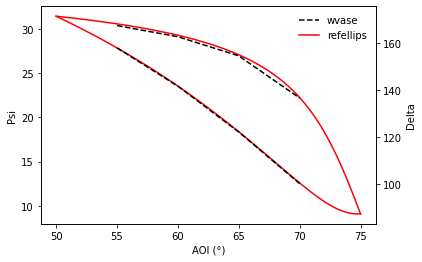

In [10]:
fig, ax = plt.subplots()
axt = ax.twinx()

aois = np.linspace(50,75,100)
psi, delta = model(aois)

ax.plot(WVASE_test['Angle of Incidence'], WVASE_test['Psi'],ls='--', color='k', zorder=5, label='wvase')
axt.plot(WVASE_test['Angle of Incidence'], WVASE_test['Delta'],ls='--', color='k', zorder=5)

ax.plot(aois, psi, color='r', label='refellips')
axt.plot(aois, delta, color='r')

ax.legend(frameon=False)
ax.set(ylabel='Psi', xlabel='AOI (°)')
axt.set(ylabel='Delta')
plt.show()

# Fitting experimental data

### Model & data pre fit

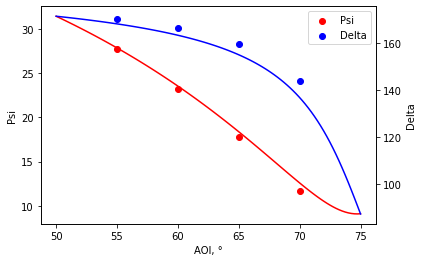

In [11]:
fig, ax = plt.subplots()
axt = ax.twinx()

aois = np.linspace(50,75,100)
psi, delta = model(aois)
ax.plot(aois, psi, color='r')
p = ax.scatter(data.aoi, data.psi, color='r')

axt.plot(aois, delta, color='b')
d = axt.scatter(data.aoi, data.delta, color='b')

ax.legend(handles=[p,d], labels=['Psi', 'Delta'])
ax.set(ylabel='Psi', xlabel='AOI, °')
axt.set(ylabel='Delta')
plt.show()

In [12]:
objective = ObjectiveSE(model, data)

In [13]:
fitter = CurveFitter(objective)
fitter.fit(method='differential_evolution');

You must install the tqdm library to use progress indicators with emcee


### Model & data post fit

In [ ]:
fig, ax = plt.subplots()
axt = ax.twinx()

aois = np.linspace(50,75,100)
psi, delta = model(aois)
ax.plot(aois, psi, color='r')
p = ax.scatter(data.aoi, data.psi, color='r')

axt.plot(aois, delta, color='b')
d = axt.scatter(data.aoi, data.delta, color='b')

ax.legend(handles=[p,d], labels=['Psi', 'Delta'])
ax.set(ylabel='Psi', xlabel='AOI, °')
axt.set(ylabel='Delta')
plt.show()

In [ ]:
for i, x in enumerate(objective.model.parameters):
    print(x)